In [16]:
import splitfolders
input_folder='Apparel_Amazon\Input_Dataset'
output_folder='Apparel_Amazon\Processed_Dataset'
splitfolders.ratio(input_folder,output_folder,seed=42,ratio=(.6,.2,.2))

Copying files: 3600 files [00:09, 398.77 files/s]


In [28]:
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input,decode_predictions
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
import pandas as pd
import seaborn as sns


In [18]:
img_height,img_width=(224,224)
batch_size=32

In [19]:
train_data_dir=r"Apparel_Amazon\Processed_Dataset\train"
test_data_dir=r"Apparel_Amazon\Processed_Dataset\test"
validation_data_dir=r"Apparel_Amazon\Processed_Dataset\val"

In [20]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.4)


train_generator=train_datagen.flow_from_directory(train_data_dir,
                                       target_size=(img_height,img_width),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                                 subset='training')


validation_generator=train_datagen.flow_from_directory(validation_data_dir,
                                       target_size=(img_height,img_width),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                                 subset='validation')


Found 1296 images belonging to 3 classes.
Found 288 images belonging to 3 classes.


In [21]:
test_generator=train_datagen.flow_from_directory(test_data_dir,
                                       target_size=(img_height,img_width),
                                       batch_size=1,
                                       class_mode='categorical',
                                                 subset='validation')

Found 288 images belonging to 3 classes.


In [22]:
train_generator.num_classes

3

In [23]:
base_model=ResNet50(include_top=False)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)

predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable=False





In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.fit(train_generator,epochs=10)

Epoch 1/10
41/41 [==============================] - 52s 1s/step - loss: 0.8955 - accuracy: 0.7827
Epoch 2/10
41/41 [==============================] - 50s 1s/step - loss: 0.1261 - accuracy: 0.9460
Epoch 3/10
41/41 [==============================] - 50s 1s/step - loss: 0.0633 - accuracy: 0.9674
Epoch 4/10
41/41 [==============================] - 50s 1s/step - loss: 0.0298 - accuracy: 0.9930
Epoch 5/10
41/41 [==============================] - 53s 1s/step - loss: 0.0275 - accuracy: 0.9940
Epoch 6/10
41/41 [==============================] - 53s 1s/step - loss: 0.0153 - accuracy: 0.9970
Epoch 7/10
41/41 [==============================] - 51s 1s/step - loss: 0.0101 - accuracy: 0.9976
Epoch 8/10
41/41 [==============================] - 52s 1s/step - loss: 0.0087 - accuracy: 0.9991
Epoch 9/10
41/41 [==============================] - 54s 1s/step - loss: 0.0062 - accuracy: 0.9989
Epoch 10/10
41/41 [==============================] - 52s 1s/step - loss: 0.0053 - accuracy: 0.9993


In [26]:
model.save('Apparel_Amazon\Processed_Dataset\Apparel_Prediction.h5')

In [27]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)

288/288 - 16s - loss: 0.0214 - accuracy: 0.9861


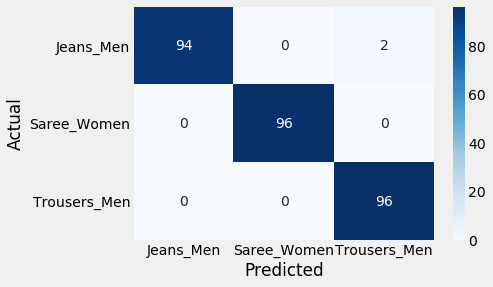

Test Accuracy : 99.30555555555556


In [30]:
model=tf.keras.models.load_model('Apparel_Amazon\Processed_Dataset\Apparel_Prediction.h5')
filename=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    x_test,y_test=test_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)
    
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class= [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]
out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('Test Accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))